In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
import re
import string
from nltk import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [3]:
#---------------STARTING WITH R8----------------------------
##------------BUILDING THE DATASET
X_train = pd.read_csv('datasets/r8-train-all-terms.txt', sep="\t", header=None)
X_test = pd.read_csv('datasets/r8-test-all-terms.txt', sep="\t", header=None)
data_r8=pd.concat([X_train,X_test], ignore_index=True)
data_r8.columns = ["class", "text"]

#nb of classes
classes_count = data_r8.groupby('class').count().sort_values(by=['text'],ascending=False)

# I- PreProcessing

In [4]:
!pip install unidecode

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from unidecode import unidecode
from nltk import SnowballStemmer
import re
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
text = data_r8.text

#df to a list
rows = text.apply(''.join).tolist()

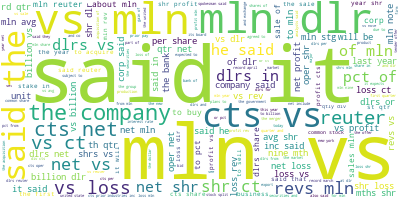

In [7]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different descriptions together.
long_string = ''.join(str(v) for v in text)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

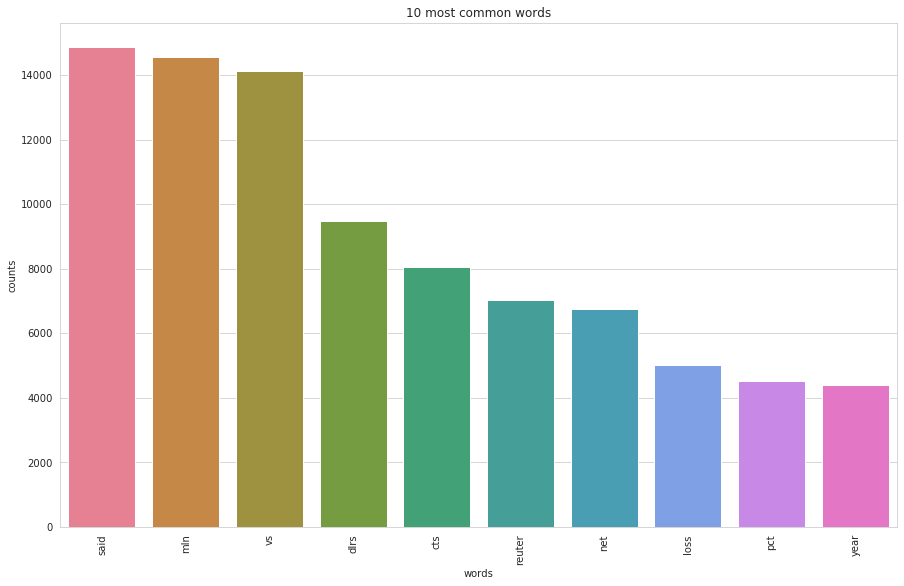

In [8]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(max_df=0.95,stop_words='english')
# Fit and transform the processed descriptions
count_data = count_vectorizer.fit_transform(text)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## 1. Stop Words and Stemming¶

In [9]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [10]:
language = 'english'
rows_clean = processCorpus(rows, language)
rows_clean[13][0:460]

'handi harman hnh qtr loss shr loss cts loss three cts net loss loss rev mln mln month shr loss cts profit cts net loss profit rev mln mln note net loss qtr includ charg restructur mln dlrs tax cts share net loss includ tax special charg mln dlrs cts share reuter'

# II- CoClustering

## 1- Tfidf

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text  import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.7,min_df=0.0005)
#min_df:When building the vocabulary ignore terms that have a documentfrequency strictly lower than the given threshold. 
#max_df:When building the vocabulary ignore terms that have a documentfrequency strictly higher than the given threshold

X = vectorizer.fit_transform(rows_clean)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

final_df.to_csv(r'final_df.csv', index = False)

print("shape = {}".format(final_df.shape))

## 2- Word2Vec

In [ ]:
# list of words for each document
words = []
for sublist in rows_clean:
    w = sublist.split()
    words.append(w)

# list that regroups all the words
words_flat = []
for sublist in words:
    for item in sublist:
        words_flat.append(item)

#remove duplicates
def remove_duplicates(l):
    return list(set(l))

vocabulary = remove_duplicates(words_flat)

In [65]:
#https://www.kaggle.com/alvations/word2vec-embedding-using-gensim-and-nltk
from gensim import models
from gensim.models import Word2Vec

# vocab =  1000000 word 
model_pretrained = models.KeyedVectors.load_word2vec_format('models_word2vec/GoogleNews-vectors-negative300.bin.gz', binary=True,limit = 1000000)

In [33]:
import gensim
from gensim.models.word2vec import Word2Vec
# Load the binary model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary = True);

# Only output word that appear in the Brown corpus
words = set(brown.words())
print (len(words))

# Output presented word to a temporary file
out_file = 'pruned.word2vec.txt'
f = open(out_file,'wb')

word_presented = words.intersection(model.vocab.keys())
f.write('{} {}\n'.format(len(word_presented),len(model['word'])))

for word in word_presented:
    f.write('{} {}\n'.format(word, ' '.join(str(value) for value in model[word])))

f.close()

1000000